In [1]:
import random
import pickle
import math
import scipy as sp
import scipy.stats as sps
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [3]:
model = SequenceModel(input_size=1657,
                      output_dim=1657,
                      hidden_size=128,
                      num_layers=1)

In [4]:
model.load_state_dict(torch.load( "ckpt/model.ckpt"))
model.eval()

SequenceModel(
  (lstm): LSTM(1657, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1657, bias=True)
)

In [5]:
with open("./ckpt/Z.pickle", "rb") as f:
    Z = pickle.load(f)
    
with open("./ckpt/scaler.pickle", "rb") as f:
    scaler = pickle.load(f)

In [6]:
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

In [7]:
for_header = pd.read_csv("./Memory_metric_sort.csv", sep=',', index_col=False)
headers = list(for_header.keys())

In [8]:
############Load New data set for Marking anomal position##################
############please add new data which includes anomal data set#############
##2) 모델로 비정상 포함 데이터셋에 Z뽑기 --> 여기에 모든 리소스의 이상한 값들이 들어간 데이터셋을 사용
#비슷한 갯수로 작업.. 데이터는 다르게
Z_anormal_CPU = []
window_size = 10
batch_size =192

anormal_CPU = pd.read_csv("./cpu_increase_100.csv", sep=',', index_col=False)
anormal_CPU = anormal_CPU[headers]
#anormal_CPU = anormal_CPU[anormal_CPU.fault ==1][headers]
anormal_CPU = anormal_CPU.to_numpy()
anormal_CPU = scaler.transform(anormal_CPU)


batch_list = make_batch(anormal_CPU, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    anormal_CPU_v, anormal_cpu_z = model(batch_input)
    Z_anormal_CPU.append(anormal_cpu_z.detach().numpy())
    
Z_anormal_mem = []
window_size = 10
batch_size =192

anormal_mem = pd.read_csv("./MEM_100_0914.csv", sep=',', index_col=False)
anormal_mem = anormal_mem[headers]
anormal_mem = anormal_mem.to_numpy()
anormal_mem = scaler.transform(anormal_mem)


batch_list = make_batch(anormal_mem, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    anormal_mem_v, anormal_mem_z = model(batch_input)
    Z_anormal_mem.append(anormal_mem_z.detach().numpy())    
    
    
Z_anormal_net = []
window_size = 10
batch_size =192

anormal_net = pd.read_csv("./Network_metric.csv", sep=',', index_col=False)[headers]

anormal_net = anormal_net.to_numpy()
anormal_net = scaler.transform(anormal_net)


batch_list = make_batch(anormal_net, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    anormal_net_v, anormal_net_z = model(batch_input)
    Z_anormal_net.append(anormal_net_z.detach().numpy())        

    
    


In [9]:
####4) 정상 데이터셋을 모델로 Z_normal뽑기  

Z_normal = []
normal = pd.read_csv("./normal-mini0913_art.csv", sep=',', index_col=False)
normal =normal[headers]


normal = normal.to_numpy()
normal = scaler.transform(normal)

batch_list = make_batch(normal, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    normal_v, normal_z = model(batch_input)
    Z_normal.append(normal_z.detach().numpy())    

In [10]:
#### 5) 비정상 샘플포인트 모델로 sample_neg_z 뽑기
# CPU 메모리  네트워크 등의 장애 샘플 포인트를 넣어서 마킹?


##CPU
sample_neg = pd.read_csv("./cpu_increase_100.csv", sep=',', index_col=False)
sample_neg = sample_neg[headers]
sample_neg = sample_neg.to_numpy()
sample_neg = scaler.transform(sample_neg)


# ##CPU ______Samples for quering
sample_neg = sample_neg[43:86] 
sample_neg = np.array(sample_neg)  # sequence_length x featbure size
sample_neg = torch.tensor(sample_neg, dtype=torch.float32)  # sequence_length x feature size
sample_neg = sample_neg.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_CPU, z_prime_CPU = model(sample_neg)    
z_prime_CPU = z_prime_CPU.detach().numpy()

#Memory
sample_neg2 = pd.read_csv("./MEM_100_0914.csv", sep=',', index_col=False)
sample_neg2 = sample_neg2[headers]
sample_neg2 = sample_neg2.to_numpy()
sample_neg2 = scaler.transform(sample_neg2)


# ##MEM ______Samples for quering
sample_neg2 = sample_neg2[21:60] 
sample_neg2 = np.array(sample_neg2)  # sequence_length x featbure size
sample_neg2 = torch.tensor(sample_neg2, dtype=torch.float32)  # sequence_length x feature size
sample_neg2 = sample_neg2.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_MeM, z_prime_MeM = model(sample_neg2)    
z_prime_MeM = z_prime_MeM.detach().numpy()


#Network
sample_neg3 = pd.read_csv("./Network_metric_sort.csv", sep=',', index_col=False)
sample_neg3 = sample_neg3.to_numpy()
sample_neg3 = scaler.transform(sample_neg3)


 ##Network ______Samples for quering
sample_neg3 = sample_neg3[21:60]
sample_neg3 = np.array(sample_neg3)  # sequence_length x featbure size
sample_neg3 = torch.tensor(sample_neg3, dtype=torch.float32)  # sequence_length x feature size
sample_neg3 = sample_neg3.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_network, Z_prime_network = model(sample_neg3)    
Z_prime_network = Z_prime_network.detach().numpy()

In [60]:
####6) Z_normal, z_prime_neg 를 pca. transform

# ======================================
# Visualize latent space

pca = PCA(n_components=2)
Z_normal = np.concatenate(Z_normal)
Z_anormal_CPU = np.concatenate(Z_anormal_CPU)
Z_anormal_mem = np.concatenate(Z_anormal_mem) 
Z_anormal_net = np.concatenate(Z_anormal_net) 

#z_prime_CPU = z_prime_CPU.reshape((1,-1))
#z_prime_MeM = z_prime_MeM.reshape((1,-1))
#z_prime_network = z_prime_network.reshape((1,-1))


#print(Z_anormal.shape)
#print(Z_normal.shape)
#print(z_prime_CPU.shape)
#print(z_prime_MeM.shape)
#print(z_prime_network.shape)
Z = np.concatenate([Z_normal, Z_anormal_CPU, Z_anormal_mem, Z_anormal_net])
label = ['normal']*len(Z_normal) + ['cpu_error']*len(Z_anormal_CPU) + ['mem_error']*len(Z_anormal_mem) + ['net_error']*len(Z_anormal_net)

In [94]:
Z.shape

(2520, 128)

In [62]:
len(label)

2520

In [63]:
sample_neg = pd.read_csv("./MEM_100_0914.csv", sep=',', index_col=False)
sample_neg = sample_neg[headers]
sample_neg = sample_neg.to_numpy()
sample_neg = scaler.transform(sample_neg)


# ##CPU ______Samples for quering
sample_neg = sample_neg[43:86][3:13]
sample_neg = np.array(sample_neg)  # sequence_length x featbure size
sample_neg = torch.tensor(sample_neg, dtype=torch.float32)  # sequence_length x feature size
sample_neg = sample_neg.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_CPU, z_prime_CPU = model(sample_neg)    
z_prime_CPU = z_prime_CPU.detach().numpy()

In [64]:
distance_matrix = pairwise_distances(z_prime_CPU, Z)

In [65]:
distance_matrix.shape

(1, 2520)

In [66]:
distance_matrix = distance_matrix.flatten()

In [67]:
distance_matrix.shape

(2520,)

In [68]:
idxs = distance_matrix.argsort()

In [69]:
idxs[:5]

array([   0, 1632, 1633, 1634, 1635])

In [70]:
distance_matrix[idxs[:5]]

array([0., 0., 0., 0., 0.], dtype=float32)

In [71]:
top_reason = []
for idx in idxs[:5]:
    top_reason.append(label[idx])

In [72]:
top_reason

['normal', 'mem_error', 'mem_error', 'mem_error', 'mem_error']

In [73]:
distance_matrix[idxs[0]]

0.0

In [74]:
len(Z_anormal_mem),  len(Z_anormal_net)

(1186, 68)

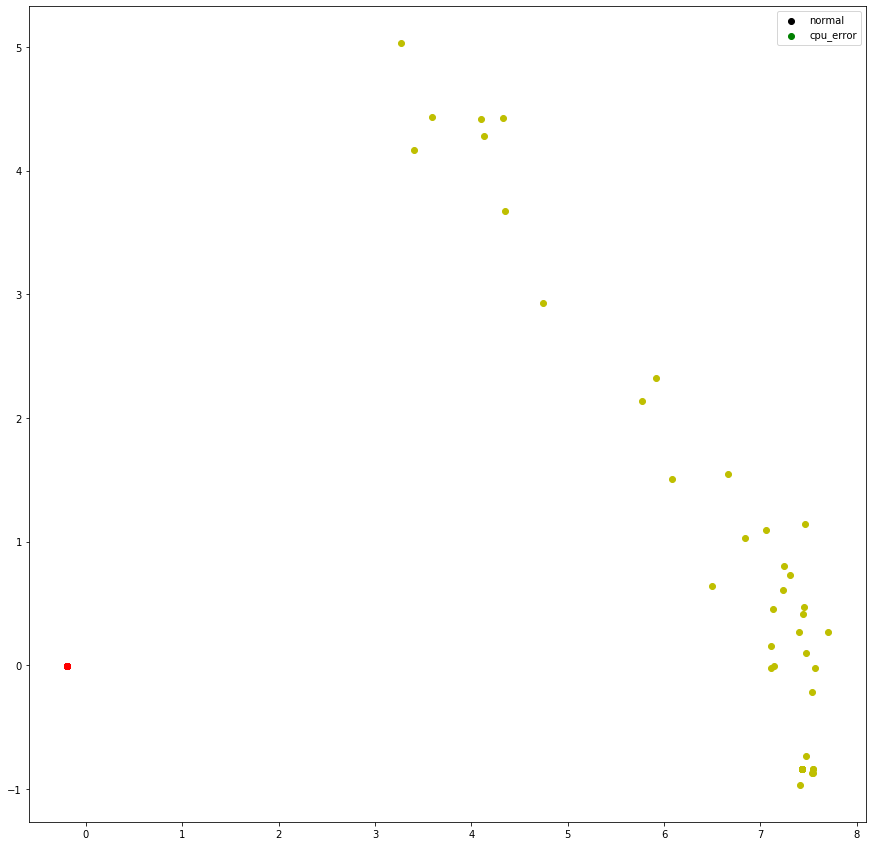

In [75]:
#Z = np.concatenate([Z_normal, Z_anormal, z_prime_CPU, z_prime_MeM, z_prime_network])
pca.fit(Z)

Z_2d = pca.transform(Z)
z_prime_CPU = pca.transform(z_prime_CPU)
z_prime_MeM = pca.transform(z_prime_MeM)
Z_prime_network = pca.transform(Z_prime_network)

plt.figure(figsize=(15,15))

plt.scatter(Z_2d[:len(Z_normal), 0], Z_2d[:len(Z_normal), 1], color='k', label='normal')

plt.scatter(Z_2d[len(Z_normal):len(Z_normal)+len(Z_anormal_CPU), 0], Z_2d[len(Z_normal):len(Z_normal)+len(Z_anormal_CPU), 1], color='g',label='cpu_error')


plt.scatter(Z_2d[len(Z_normal)+len(Z_anormal_CPU):len(Z_normal)+len(Z_anormal_CPU)+len(Z_anormal_mem), 0],
            Z_2d[len(Z_normal)+len(Z_anormal_CPU):len(Z_normal)+len(Z_anormal_CPU)+len(Z_anormal_mem), 1], color='r')

plt.scatter(Z_2d[len(Z_normal)+len(Z_anormal_CPU)+len(Z_anormal_mem):, 0],
            Z_2d[len(Z_normal)+len(Z_anormal_CPU)+len(Z_anormal_mem):, 1], color='y')


# plt.scatter(z_prime_CPU[:, 0],z_prime_CPU[:, 1] , color='purple', s=10, label='CPU')
# plt.scatter(z_prime_MeM[:, 0],z_prime_MeM[:, 1] , color='blue', s=10, label='MEM')
# plt.scatter(Z_prime_network[:, 0],Z_prime_network[:, 1] , color='pink', s=10, label='NET')
plt.legend()
plt.show()

In [76]:
len(Z_normal), len(Z_anormal_CPU), len(Z_anormal_mem), len(Z_anormal_net)

(1188, 78, 1186, 68)

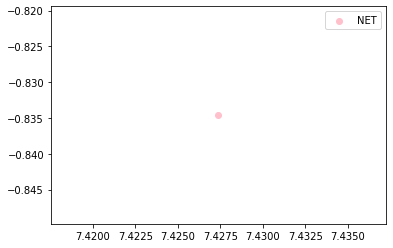

In [77]:
plt.scatter(Z_prime_network[:, 0],Z_prime_network[:, 1] , color='pink', label='NET')
plt.legend()
plt.show()

In [78]:
Z_anormal_net.shape

(68, 128)

In [79]:
np.std(Z_anormal_net, axis=0)

array([0.09167539, 0.09167542, 0.21084873, 0.2931615 , 0.25695926,
       0.23979111, 0.23896945, 0.15957426, 0.3898474 , 0.09167528,
       0.21601631, 0.17143118, 0.53045636, 0.3604269 , 0.2627358 ,
       0.2804455 , 0.49652103, 0.09167542, 0.1563982 , 0.        ,
       0.        , 0.32645237, 0.3039855 , 0.15957414, 0.15957414,
       0.14680837, 0.        , 0.58871514, 0.        , 0.38846108,
       0.23245054, 0.1833505 , 0.3658449 , 0.3215849 , 0.1922854 ,
       0.21552637, 0.18335077, 0.1922854 , 0.2795584 , 0.18335077,
       0.31925014, 0.57903737, 0.3622411 , 0.16287994, 0.40983123,
       0.36224082, 0.12867722, 0.3518629 , 0.4355024 , 0.19810948,
       0.23143482, 0.1563982 , 0.14974385, 0.3019086 , 0.22669618,
       0.16203181, 0.23758289, 0.12037282, 0.18158376, 0.15957426,
       0.2471435 , 0.44550225, 0.11977745, 0.44524625, 0.44550094,
       0.33570176, 0.221747  , 0.        , 0.28044546, 0.        ,
       0.20752169, 0.17919862, 0.        , 0.20878087, 0.09167

In [80]:
########### anomaly detection #################
#1) put the newdata into the model

newdata = pd.read_csv("./cpu_increase_art_357100.csv", sep=',', index_col=False)
newdata =newdata[headers]
newdata = newdata.to_numpy()

newdata = scaler.transform(newdata)

Z_newdata = []


reconstruction_error_new =[]

for i in range(len(newdata) - window_size - 1):
    batch_input = newdata[i: i + window_size]
    batch_input = torch.tensor(batch_input, dtype=torch.float32).unsqueeze(0)
    new_v, new_z = model(batch_input)
    Z_newdata.append(new_z.detach().numpy())
    reconstruction_error_new.append(torch.sum(torch.abs(new_v[:, :-1, :] - batch_input[:, 1:, :] )).item())

In [81]:
#2) Laading PDF value and get proability of error.

##Loading PDF value
f = open("./ckpt/pdf.txt", 'r')
line = f.readline()
rce_std, rce_mean  = line.split()
f.close()

In [82]:
##get proability of error.

# new_v: 1 x seq len x n feature

#Z = np.array(Z)
#하나씩 하는것과 나눠서 하는것 차이가없는지..

reconstruction_error_new = np.array(reconstruction_error_new, dtype=np.float)

rce_std = float(rce_std)
rce_mean = float(rce_mean)
print(rce_std,rce_mean)
rv = sps.norm(loc=rce_mean, scale=rce_std)
maxg = rv.pdf(rce_mean)
print('maxg', maxg)

258.1379220917833 774.0276560927882
maxg 0.0015454617328932597


In [83]:
pdf = rv.logpdf(reconstruction_error_new)

In [84]:
len(pdf), len(reconstruction_error_new)
print(reconstruction_error_new)

[1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.03764176e+17 1.03764176e+17 1.03764176e+17
 1.03764176e+17 1.037641

In [85]:
reconstruction_error_new[40]

1.0376417648836608e+17

In [86]:

#pdf = (reconstruction_error_new - rce_mean)/rce_std

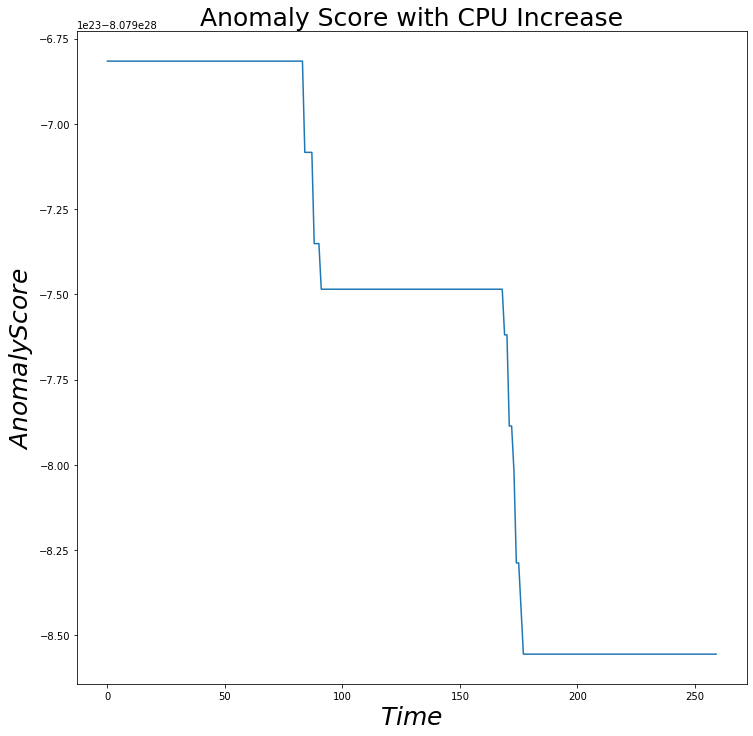

[-8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906

In [87]:
plt.figure(figsize=(12,12))
plt.plot(range(len(pdf)), pdf)

plt.title("Anomaly Score with CPU Increase", fontsize=25)
plt.xlabel("$Time$", fontsize=25)
plt.ylabel("$Anomaly Score$", fontsize=25)
plt.show()
print(pdf)

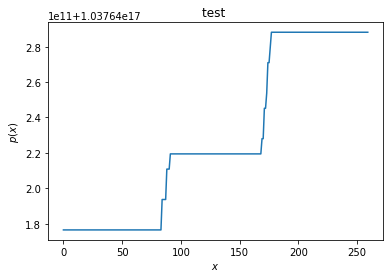

In [88]:
plt.plot(range(len(reconstruction_error_new)), reconstruction_error_new)
plt.title("test ")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.show()

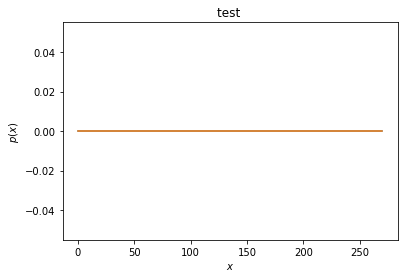

In [89]:
plt.plot(range(len(newdata)), newdata[:, 45])
plt.plot(range(len(newdata)), newdata[:, 46])
plt.title("test ")
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.show()

In [90]:
rce_mean, rce_std

(774.0276560927882, 258.1379220917833)

In [91]:
rce_mean - rce_std, rce_mean + rce_std

(515.8897340010049, 1032.1655781845716)

In [92]:
newdata

array([[   0.        ,    0.        , -411.7898564 , ...,  -18.00440336,
         -35.41029177,  -18.52678769],
       [   0.        ,    0.        , -411.78973378, ...,  -18.00438843,
         -35.41032143,  -18.5268016 ],
       [   0.        ,    0.        , -411.78955081, ...,  -18.00440901,
         -35.41035053,  -18.52674593],
       ...,
       [   0.        ,    0.        , -411.78972511, ...,  -18.00430451,
         -35.41034941,  -18.52680203],
       [   0.        ,    0.        , -411.78918731, ...,  -18.00431096,
         -35.41028002,  -18.52674678],
       [   0.        ,    0.        , -411.78981283, ...,  -18.00440498,
         -35.4103371 ,  -18.52678642]])

In [93]:
print("PDF", pdf)
print("rate", (pdf/maxg)*100)

if 60 <= pdf <=80 :
    print("caution")
    #curl 127.0.0.1:{PORT}/nsfs/nsf1/nsf2/1

elif 80 < pdf :
    print("error?")
    #curl 127.0.0.1:{PORT}/nsfs/nsf1/nsf2/1
    
    
elif 95 < pdf :
    print("end")
    #curl 127.0.0.1:{PORT}/nsfs/nsf1/nsf2/1  

PDF [-8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28 -8.07906816e+28
 -8.07906816e+28 -8.0

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
dist = pairwise_distances(Z_newdata, z_prime_CPU)

In [ ]:
# Plot Reconstruction Error 
neg_height = 1
min_val = min(min(reconstruction_error), min(reconstruction_error_neg))
max_val = max(max(reconstruction_error), max(reconstruction_error_neg))
bins = np.linspace(min_val, 
                   max_val,
                   100)

plt.hist(reconstruction_error_neg * neg_height, bins=bins, alpha=0.5, color='red', label='abnormal')
plt.hist(reconstruction_error, bins=bins, alpha=0.5,color='k', label='normal')
plt.legend()
plt.show()